#### Heuristics about betting and true count
The most common strategy for betting based on the true count is to use a multiplier for your base bet (say 1) according to the counter.
A reasonable choice for a simple betting strategy is the following:
- Non-positive true count (0 or below): 1x base bet
- Positive mid true count (1 to 5): 4x base bet (could be split in 2x and 4x)
- Positive high true count (6 or above): 8x base bet \
Our goal: make the agent learn this betting strategy, which should yield a higher expected reward than simply betting 1 \
Assumption: all games are played according to the basic strategy

In [ ]:
import numpy as np
import pandas as pd
import os
os.chdir('..')
os.chdir('src')
from utils import *
from env import BlackjackEnv

In [40]:
os.chdir('..')
os.chdir('strategies')
# Load the strategy CSV file
q_table_strat = parse_strategy_csv('dq_h_s_dd_strat.csv')
basic_strat = parse_strategy_csv('basic_strat_doub.csv')

In [41]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1, 4, 8],
    "actions": ["stand", "hit", "double"],
    "num_players": 1
}

env = BlackjackEnv(config)

### Helper functions

In [42]:
def get_q_values(state_features, q_table=q_table_strat):
    """Get Q-values for a given state"""
    if state_features in q_table:
        return np.array([q_table[state_features][0], q_table[state_features][1], q_table[state_features][2]])
    else:
        # Return default values based on player sum
        player_sum = state_features[0]
        if player_sum < 12:
            return np.array([-0.1, 0.5, 0.0])  # Default to hit for low sums
        elif player_sum >= 20:
            return np.array([0.5, -0.1, 0.0])  # Default to stand for high sums
        else:
            return np.array([0.0, 0.0, 0.0])  # Neutral for middle sums

In [43]:
def update_q_value(true_count, bet_amount, reward, next_true_count, lr, terminal, q_table, target_q_table, gamma):
    """Update Q-value for true_count-bet pair using Double Q-learning."""
    
    # Current Q-value
    current_q = q_table[true_count][bet_amount]
    if reward > 1.5:
        reward = 1.2
    elif reward < -1:
        reward = -1.2
    
    if terminal or next_true_count is None:
        # Terminal state - no future rewards
        new_q = current_q + lr * (reward - current_q)
    else:
        # Get the next state's best action from current Q-table
        best_next_bet = max(q_table[next_true_count], key=q_table[next_true_count].get)
        
        # Get Q-value for best action from target Q-table
        max_next_q = target_q_table[next_true_count][best_next_bet]
        
        # Q-learning update formula with future rewards
        new_q = current_q + lr * (reward + gamma * max_next_q - current_q)
    
    # Update the Q-table entry
    q_table[true_count][bet_amount] = new_q
    
    return q_table

In [44]:
def smart_exploration(true_count, epsilon, q_table_1, q_table_2, true_count_visits):
    """Smart exploration strategy based on true count visit frequency."""
    
    # Count-based exploration: make rarely seen true counts more likely to be explored
    visit_count = true_count_visits[true_count]
    exploration_bonus = 1.0 / (1.0 + visit_count / 1000)  # Normalize visit count
    adjusted_epsilon = min(0.9, epsilon + exploration_bonus)
    
    # Decide to explore or exploit
    if np.random.rand() < adjusted_epsilon:
        # Explore - but with a bias towards higher bets for high counts
        num_bets = len(config["bet_size"])
        if true_count >= 2:
            # With high count, bias towards higher bets during exploration
            bet_probs = np.linspace(0.1, 0.9, num_bets)
        elif true_count == 0:
            # With low/negative count, bias towards lower bets
            bet_probs = np.linspace(0.9, 0.1, num_bets)
        else:
            # Neutral count, uniform exploration
            bet_probs = np.full(num_bets, 1.0 / num_bets)
        
        # Normalize probabilities to ensure they sum to 1
        bet_probs /= bet_probs.sum()
        bet_amount = np.random.choice(config["bet_size"], p=bet_probs)
    else:
        # Exploit: use average of both Q-tables to determine best bet
        avg_q_values = {}
        for bet in config["bet_size"]:
            avg_q_values[bet] = (q_table_1[true_count][bet] + q_table_2[true_count][bet]) / 2
        
        bet_amount = max(avg_q_values, key=avg_q_values.get)
    
    # Update visit count for this true count
    true_count_visits[true_count] += 1
    
    return bet_amount

### Q table initialization for betting

In [ ]:
q_table_bet_1 = {}
q_table_bet_2 = {}
# Initialize the Q-table for betting based on the true count using a dictionary
for i in range(0, 3):
    q_table_bet_1[i] = {bet: 0.0 for bet in config["bet_size"]}
    q_table_bet_2[i] = {bet: 0.0 for bet in config["bet_size"]}
    # Initialize with some bias based on betting theory:
    # - Higher bets are better for high counts (card counting advantage)
    # - Lower bets are better for low or negative counts
    for bet in config["bet_size"]:
        if i >= 1 and bet > 1:  # High count, higher bet might be better
            q_table_bet_1[i][bet] = 0.1 * bet * i / 5
            q_table_bet_2[i][bet] = 0.1 * bet * i / 5
        elif i == 0 and bet == 1:  # Negative count, minimum bet is better
            q_table_bet_1[i][bet] = 0.5
            q_table_bet_2[i][bet] = 0.5
        elif i == 0 and bet > 1:  # Negative count, higher bet is worse
            q_table_bet_1[i][bet] = -0.5
            q_table_bet_2[i][bet] = -0.5

# True count visit tracking for exploration bias
true_count_visits = {i: 0 for i in range(0, 3)}

### Hyperparameters

In [47]:
# Hyperparameters
initial_alpha = 0.1  # Starting learning rate
min_alpha = 0.0005  # Minimum learning rate
decay_rate = 0.99999  # Decay rate for learning rate
gamma = 0.95  # Discount factor
starting_epsilon = 1.0  # Exploration rate
epsilon_decay = 0.99999  # Decay rate for exploration
min_epsilon = 0.01  # Minimum exploration rate

### Training process

In [ ]:
# Implement the learning process for betting
print("\nStarting betting learning process...")

episodes = 4000000
epsilon = starting_epsilon
alpha = initial_alpha
episode = 0

stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'money won': 0,
    'money lost': 0,
}

while episode < episodes:
    # Reset the environment and get the true count
    observation = env.reset()
    true_count = get_true_count(observation)

    true_count = discretize_true_count(true_count)

    bet_amount = smart_exploration(true_count, epsilon, q_table_bet_1, q_table_bet_2, true_count_visits)

    # Perform the betting action
    bet_index = config["bet_size"].index(bet_amount)
    state, reward, done, _ = env.step(bet_index, action_type="bet")

    if done:
        # Update Q-value using the reward
        next_true_count = discretize_true_count(state["true_count"])

        if np.random.rand() < 0.5: #epsilon
            q_table_bet_1 = update_q_value(true_count, bet_amount, reward, next_true_count, alpha, done, q_table_bet_1, q_table_bet_2, gamma)
        else:
            q_table_bet_2 = update_q_value(true_count, bet_amount, reward, next_true_count, alpha, done, q_table_bet_2, q_table_bet_1, gamma)
        if reward > 0:
            stats['wins'] += 1
            stats['money won'] += reward * bet_amount
        elif reward == 0:
            stats['draws'] += 1
        else:
            stats['losses'] += 1
            stats['money lost'] += abs(reward) * bet_amount
    else:
        # Continue playing the game according to the strategy 
        state_features = get_state_features(state)
        double_down = False
        while not done:

            if state_features[0] < 9:
            # Always hit this state as it's not relevant for our training
                next_state, _, _, _ = env.step(1, action_type="move")
                next_state_features = get_state_features(next_state) if not done else None
                state = next_state
                state_features = next_state_features if next_state is not None else None
                continue

            # Choose the best action based on the basic strategy (instead of the learnt strategy, simply to facilitate the learning process)
            q_values = get_q_values(state_features, basic_strat)
            action = np.argmax(q_values)

            if action == 2:
                # Double down action
                double_down = True

            # Perform the action
            next_state, reward, done, _ = env.step(action, action_type="move")
            state = next_state
            state_features = get_state_features(state)
        
        next_true_count = discretize_true_count(state["true_count"])

        if np.random.rand() < 0.5:
            q_table_bet_1 = update_q_value(true_count, bet_amount, reward, next_true_count, alpha, done, q_table_bet_1, q_table_bet_2, gamma)
        else:
            q_table_bet_2 = update_q_value(true_count, bet_amount, reward, next_true_count, alpha, done, q_table_bet_2, q_table_bet_1, gamma)


        # Update metrics
        if reward > 0:
            stats['wins'] += 1
            stats['money won'] += reward * bet_amount
        elif reward == 0:
            stats['draws'] += 1
        else:
            stats['losses'] += 1
            stats['money lost'] += abs(reward) * bet_amount

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    alpha = get_adaptive_lr_v2(
        initial_alpha, 
        min_alpha, 
        decay_rate, 
        episode,
        true_count_visits[true_count]
    )

    episode += 1
    # Print progress every 10000 episodes
    if episode % 100000 == 0:
        print(f"Current Q-values for True Count {true_count}: {q_table_bet_1[true_count]}")
        print(f"Episode {episode}/{episodes} - Epsilon: {epsilon:.4f}, Alpha: {alpha:.4f},")

print("Betting learning process complete.")
# Print statistics
print(f"Total Wins: {stats['wins']}")
print(f"Total Draws: {stats['draws']}")
print(f"Total Losses: {stats['losses']}")
print(f"Total Money Won: {stats['money won']}")
print(f"Total Money Lost: {stats['money lost']}")
print(f"Average reward: ({(stats['money won'] - stats['money lost']) / episodes:.4f})")


Starting betting learning process...
Current Q-values for True Count 0: {1: -0.15143763482140418, 4: -0.36609849454068183, 8: 0.26047462720198383}
Episode 100000/4000000 - Epsilon: 0.3679, Alpha: 0.0697,
Current Q-values for True Count 1: {1: 0.004446521962880062, 4: 0.27096550791055973, 8: -0.47031073622351355}
Episode 200000/4000000 - Epsilon: 0.1353, Alpha: 0.0783,
Current Q-values for True Count 0: {1: -0.08821837741542701, 4: -0.034154096213644805, 8: -0.11267063361866322}
Episode 300000/4000000 - Epsilon: 0.0498, Alpha: 0.0340,
Current Q-values for True Count 1: {1: 0.05623677202164783, 4: -0.2550997980806412, 8: -0.30319564101875784}
Episode 400000/4000000 - Epsilon: 0.0183, Alpha: 0.0613,
Current Q-values for True Count 0: {1: -0.069776726027451, 4: -0.16360006425535328, 8: -0.2303241027808149}
Episode 500000/4000000 - Epsilon: 0.0100, Alpha: 0.0166,
Current Q-values for True Count 0: {1: -0.23166989744602703, 4: 0.01610192728803729, 8: -0.26119059402102224}
Episode 600000/400

### Testing: betting strategy + learnt Q-table

In [ ]:
#take the average of the two Q-tables
q_table_bet_avg = {}
for i in range(0, 3):
    q_table_bet_avg[i] = {}
    for bet in config["bet_size"]:
        q_table_bet_avg[i][bet] = (q_table_bet_1[i][bet] + q_table_bet_2[i][bet]) / 2

# Implement the learning process for betting
print("\nStarting betting testing process...")

eval_episodes = 1000000
episode = 0

# Reinitialize the environment to reset the true count
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1, 4, 8],
    "actions": ["stand", "hit", "double"],
    "num_players": 1
}
# Create environment with 6 decks (standard casino configuration)
env = BlackjackEnv(config=config)

eval_stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'money won': 0,
    'money lost': 0,
}


while episode < eval_episodes:
    # Reset the environment and get the true count
    observation = env.reset()
    true_count = get_true_count(observation)
    true_count = discretize_true_count(true_count)

    bet_amount = max(q_table_bet_avg[true_count], key=q_table_bet_avg[true_count].get)  # Exploit: best bet

    # Perform the betting action
    bet_index = config["bet_size"].index(bet_amount)
    state, reward, done, _ = env.step(bet_index, action_type="bet")

    # Update Q-values for betting
    if done:
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money won'] += reward * bet_amount
        elif reward == 0:
            eval_stats['draws'] += 1
        else:
            eval_stats['losses'] += 1
            eval_stats['money lost'] += abs(reward) * bet_amount
    else:
        # Continue playing the game according to the strategy in q_table_strat
        state_features = get_state_features(state)
        while not done:

            if state_features[0] < 9:
            # Always hit this state as it's not relevant for our training
                next_state, _, _, _ = env.step(1, action_type="move")
                next_state_features = get_state_features(next_state) if not done else None
                state = next_state
                state_features = next_state_features if next_state is not None else None
                continue

            # Choose the best action based on q_table_strat
            q_values = get_q_values(state_features, q_table_strat)
            action = np.argmax(q_values)

            # Perform the action
            next_state, reward, done, _ = env.step(action, action_type="move")
            state = next_state
            state_features = get_state_features(state)

        # Update metrics
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money won'] += reward * bet_amount
        elif reward == 0:
            eval_stats['draws'] += 1
        else:
            eval_stats['losses'] += 1
            eval_stats['money lost'] += abs(reward) * bet_amount

    episode += 1

# Print statistics
print(f"Total Wins: {eval_stats['wins']}")
print(f"Total Draws: {eval_stats['draws']}")
print(f"Total Losses: {eval_stats['losses']}")
print(f"Total Money Won: {eval_stats['money won']}")
print(f"Total Money Lost: {eval_stats['money lost']}")
print(f"Net profit: {eval_stats['money won'] - eval_stats['money lost']}")
print(f"Average reward: {(eval_stats['money won'] - eval_stats['money lost']) / eval_episodes}")



Starting betting testing process...
Total Wins: 432812
Total Draws: 86318
Total Losses: 480870
Total Money Won: 1024539.0
Total Money Lost: 1028963
Net profit: -4424.0
Average reward: -0.004424


### Benchmark: betting strategy + basic strategy

In [ ]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1,4,8],
    "actions": ["stand", "hit", "double"],
    "num_players": 1
}
# Create environment with 6 decks (standard casino configuration)
env = BlackjackEnv(config=config)

eval_episodes = 1000000
episode = 0

eval_stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'money won': 0,
    'money lost': 0,
}

while episode < eval_episodes:
    # Reset the environment and get the true count
    observation = env.reset()
    true_count = get_true_count(observation)
    true_count = discretize_true_count(true_count)

    bet_amount = max(q_table_bet_avg[true_count], key=q_table_bet_avg[true_count].get)  # Exploit: best bet

    # Perform the betting action
    bet_index = config["bet_size"].index(bet_amount)
    state, reward, done, _ = env.step(bet_index, action_type="bet")

    if done:
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money won'] += reward * bet_amount
        elif reward == 0:
            eval_stats['draws'] += 1
        else:
            eval_stats['losses'] += 1
            eval_stats['money lost'] += abs(reward) * bet_amount
    else:
        # Continue playing the game according to the strategy in basic strategy
        state_features = get_state_features(state)
        while not done:

            if state_features[0] < 9:
            # Always hit this state as it's not relevant for our training
                next_state, _, _, _ = env.step(1, action_type="move")
                next_state_features = get_state_features(next_state) if not done else None
                state = next_state
                state_features = next_state_features if next_state is not None else None
                continue

            # Choose the best action based on basic strategy
            q_values = get_q_values(state_features, basic_strat)
            action = np.argmax(q_values)

            # Perform the action
            next_state, reward, done, _ = env.step(action, action_type="move")
            state = next_state
            state_features = get_state_features(state)

        # Update metrics
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money won'] += reward * bet_amount
        elif reward == 0:
            eval_stats['draws'] += 1
        else:
            eval_stats['losses'] += 1
            eval_stats['money lost'] += abs(reward) * bet_amount

    episode += 1

# Print statistics
print(f"Total Wins: {eval_stats['wins']}")
print(f"Total Draws: {eval_stats['draws']}")
print(f"Total Losses: {eval_stats['losses']}")
print(f"Total Money Won: {eval_stats['money won']}")
print(f"Total Money Lost: {eval_stats['money lost']}")
print(f"Net profit: {eval_stats['money won'] - eval_stats['money lost']}")
print(f"Average reward: {(eval_stats['money won'] - eval_stats['money lost']) / eval_episodes}")

Total Wins: 431948
Total Draws: 86062
Total Losses: 481990
Total Money Won: 1015424.5
Total Money Lost: 1017921
Net profit: -2496.5
Average reward: -0.0024965


### Output creation

In [ ]:
os.chdir('..')
os.chdir('strategies')

# save the Q-table to a CSV file
q_table_bet_avg_df = pd.DataFrame.from_dict(q_table_bet_avg, orient='index')
# rename the index column true_count
q_table_bet_avg_df.index.name = 'true_count'

# Uncomment the following line to save the Q-table to a CSV file

# q_table_bet_avg_df.to_csv('q_table_bet_avg.csv', index=True, header=True)

### Visualization

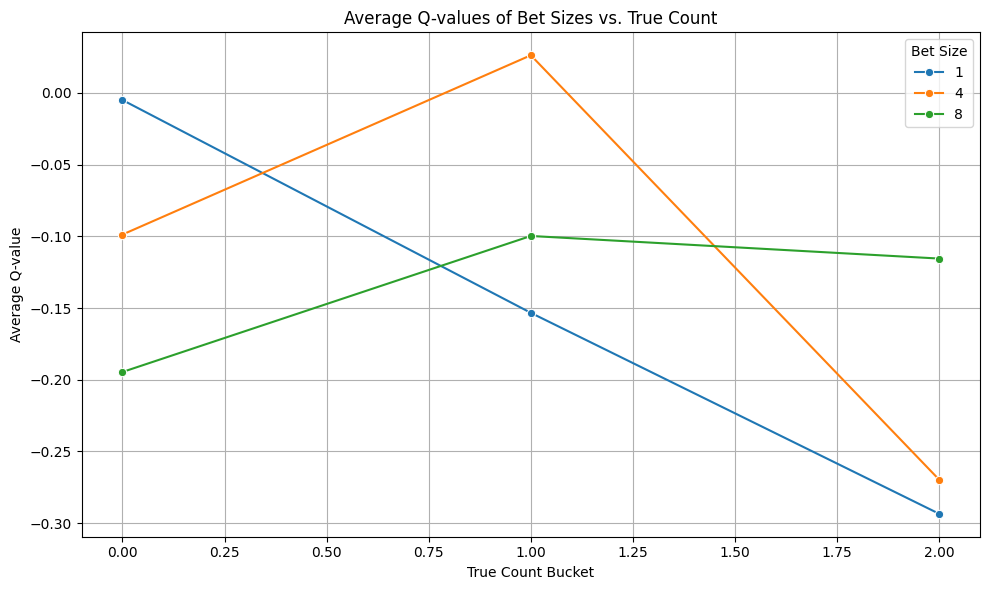

In [62]:
visualize_true_count('q_table_bet_avg.csv')